In [1]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np

In [2]:
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []
        self.debug = debug
        self.time_span = time_span
        self.time_interval = time_interval
        
    def append(self, obj):
        self.objects.append(obj)
        
    def draw(self):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        ax.set_xlabel("X", fontsize=20)
        ax.set_ylabel("Y", fontsize=20)
        
        elems = []
        
        if self.debug:
            for i in range(1000):
                self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, 
                                         self.one_step, 
                                         fargs=(elems, ax), 
                                         frames=int(self.time_span/self.time_interval)+1, 
                                         interval=int(self.time_interval*1000), 
                                         repeat=False)
            plt.show()
            
    def one_step(self, i, elems, ax):
        while elems:
            elems.pop().remove()
        time_str = "t + %2.f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(self.time_interval)
    

In [3]:
class IdealRobot:
    def __init__(self, pose, agent=None, color="black"):
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [pose]
    
    def draw(self, ax, elems):
        x, y, theta = self.pose
        xn = x + self.r * math.cos(theta)
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([x, xn], [y, yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
        elems.append(ax.add_patch(c))
        
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses],
                         [e[1] for e in self.poses],
                         linewidth=0.5, color="red")
        
    @classmethod
    def state_transition(cls, nu, omega, time, pose):
        # t0 = theta0
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            # w = 0
            return pose + np.array(
                [nu*math.cos(t0), 
                 nu*math.sin(t0), 
                 omega]) * time
        else:
            # w != 0
            return pose + np.array(
                [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)),
                 nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                 omega * time])
    
    def one_step(self, time_interval):
        if not self.agent:
            return
        nu, omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [4]:
class Agent:
    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega
    
    def decision(self, observation=None):
        return self.nu, self.omega
        

In [ ]:
class Landmark:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None
        
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0],
                       self.pos[1], 
                       s = 100, marker="*", label="landmark", color="orange")
        elems.append(c)
        elems.append(ax.text(self.pos[0], 
                             self.pos[1], 
                             "id:"+str(self.id), fontsize=10))

In [ ]:
class Map:
    def __init__(self):
        self.landmarks = []
    
    def append_landmark(self, landmark):
        landmark.id = len(self.landmarks) + 1
        self.landmarks.append(landmark)
        
    def draw(self, ax, elems):
        for lm in self.landmarks:
            lm.draw(ax, elems)

<IPython.core.display.Javascript object>


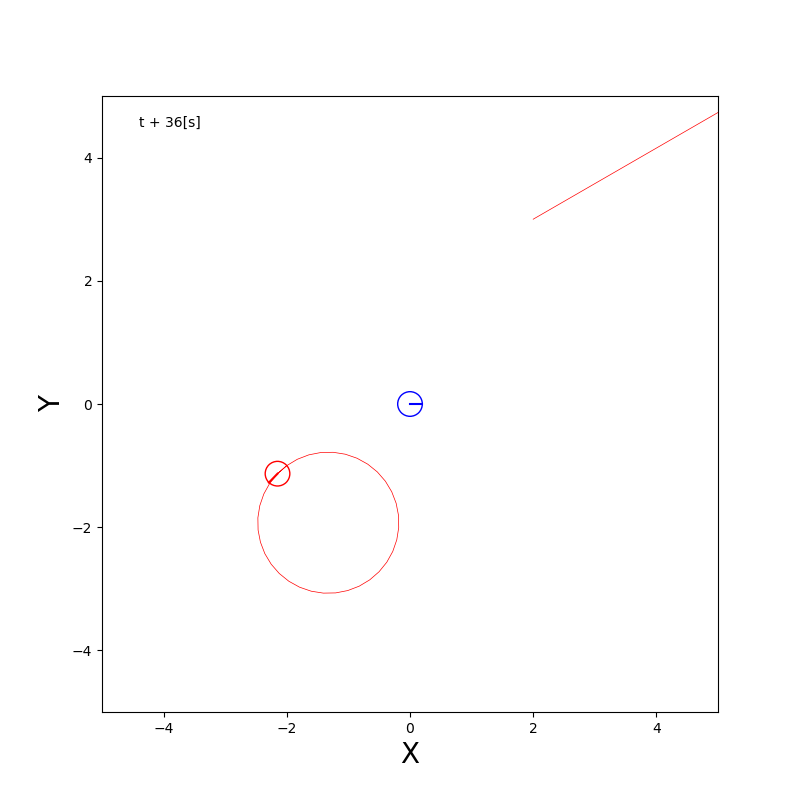

In [5]:
world = World(36, 1)
#world = World(debug=True)

m = Map()
m.append_landmark(Landmark(2, -2))
m.append_landmark(Landmark(-1, -3))
m.append_landmark(Landmark(3, 3))
world.append(m)

straight = Agent(0.2, 0.0)
circling = Agent(0.2, 10.0/180*math.pi)
robot1 = IdealRobot(np.array([2, 3, math.pi/6]).T, straight)
robot2 = IdealRobot(np.array([-2, -1, math.pi/5*6]).T, circling, color="red")
robot3 = IdealRobot(np.array([0, 0, 0]).T, color="blue")
world.append(robot1)
world.append(robot2)
world.append(robot3)
world.draw()
